# Machine Learning Nanodegree Capstone Project

### __by Gap Kim__

## Dataset for Project

In [1]:
### Sampling of training images
### Create train_sample.csv file with sampled train image url's

# reference Amanieu (https://www.kaggle.com/hyamanieu)

import pandas as pd
import numpy as np
import csv

train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
# submission = pd.read_csv("./sample_submission.csv")


In [2]:
print("train dataset structure:")
train.head()

train dataset structure:


,id,url,landmark_id
0,97c0a12e07ae8dd5,http://lh4.ggpht.com/-f8xYA5l4apw/RSziSQVaABI/...,6347
1,650c989dd3493748,https://lh5.googleusercontent.com/-PUnMrX7oOyA...,12519
2,05e63ca9b2cde1f4,http://mw2.google.com/mw-panoramio/photos/medi...,264
3,08672eddcb2b7c93,http://lh3.ggpht.com/-9fgSxDYwhHA/SMvGEoltKTI/...,13287
4,fc49cb32ef7f1e89,http://lh6.ggpht.com/-UGAXxvPbr98/S-jGZbyMIPI/...,4018


In [3]:
print("test dataset structure:")
test.head()

test dataset structure:


,id,url
0,cb9998b8cdaf6235,https://lh3.googleusercontent.com/-q8B91vDIQZY...
1,30728cf6e50a6bc6,https://lh3.googleusercontent.com/-91gJSKTgv5Q...
2,16afbc86b710337d,https://lh3.googleusercontent.com/-GHZdXuf2wMg...
3,d29b2166cf522450,https://lh3.googleusercontent.com/-cWDnYNQhyws...
4,dd5c03b20c21cfba,https://lh3.googleusercontent.com/-PSLN6BloM-k...


### Get top 100 most frequently appearing landmark_id from the original dataset

In [6]:
unique_lm = train.groupby(by='landmark_id').count().loc[:,'id']
sorted_lm = unique_lm.sort_values(ascending=False)
sorted_lm.cumsum()/sorted_lm.sum()

landmarks=train.groupby(by='landmark_id').count().loc[:,'id']
lm_stats = pd.concat([sorted_lm, sorted_lm/sorted_lm.sum(), sorted_lm.cumsum()/sorted_lm.sum()], axis=1, ignore_index=True)
lm_stats.columns=['Count', 'Proportion', 'CumSum']

top_100 = lm_stats[0 : 100] # top 100 most frequent landmark_id for image selection

train_ordered = train[train.landmark_id.isin(top_100.index)]
# select 2% of images from each landmark_id with random state 17
sample_group = train_ordered.groupby(by='landmark_id').apply(lambda x: x.sample(frac=0.02, random_state=17))
sample_index = sample_group.index.levels[1]

# sampling train data from original train dataset
train_sample = train.iloc[sample_index, :]

# write to csv file
train_sample.to_csv('train_sample.csv', index=False, quoting=csv.QUOTE_NONNUMERIC)
train_sample_df = pd.read_csv('train_sample.csv')


In [7]:
print("Total train dataset size:", train.shape[0])
print("Total test dataset size:", test.shape[0])
print("Total number of unique landmark_id's:", len(landmarks))

print("Sampled train dataset size:", train_sample.shape[0])
print("Sampled unique landmark_id's:", len(train_sample["landmark_id"].unique()))

Total train dataset size: 1225029
Total test dataset size: 117703
Total number of unique landmark_id's: 14948
Sampled train dataset size: 8586
Sampled unique landmark_id's: 100


In [8]:
train_sample.head()

,id,url,landmark_id
49,0b7ca98b7ff8c0cd,https://lh6.googleusercontent.com/-jCiqpASe2Sk...,6696
56,9c2855ff7840a378,https://lh4.googleusercontent.com/-AVEfPLKUjwQ...,2743
77,0e93f2388ca6fe45,http://lh4.ggpht.com/-vyK23KRCis4/T7T_YFZ3rQI/...,5376
89,0f2ce5981fb1d432,https://lh5.googleusercontent.com/-NUKyaAOAgas...,13332
116,3a6fb5a3c1986e54,http://lh3.ggpht.com/-DsAMtI4g2fY/Shy3HGvuHiI/...,4352


## Analysis of Reduced Dataset

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

### Frequency of landmark_id in reduced dataset

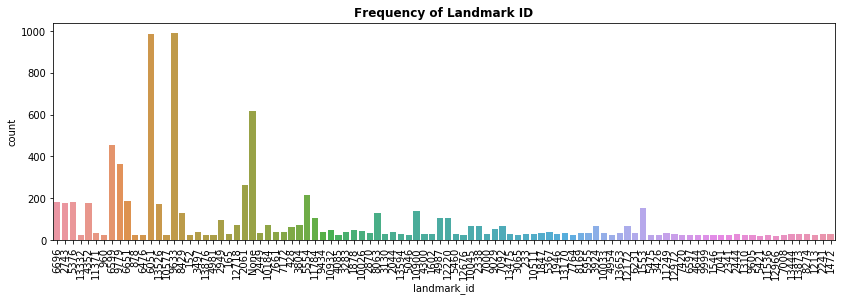

In [10]:
plt.figure(figsize = (14, 4))
g = sns.countplot(x="landmark_id", data=train_sample)
g.set_title("Frequency of Landmark ID", fontweight="bold", fontsize=12)
plt.xticks(rotation=90)
plt.show()

In [11]:
# top 10 frequent landmark_ids
train_sample['landmark_id'].value_counts()[:10]

9633    991
6051    987
None    619
6599    456
9779    362
2061    261
5554    217
6651    186
5376    181
6696    181
Name: landmark_id, dtype: int64

In [111]:
train_sample.nunique()

id             8586
url            7968
landmark_id     100
dtype: int64

In [12]:
landmark_dist = train_sample['landmark_id'].value_counts() / train_sample.shape[0]
landmark_dist.head()

9633    0.115420
6051    0.114955
None    0.072094
6599    0.053110
9779    0.042162
Name: landmark_id, dtype: float64

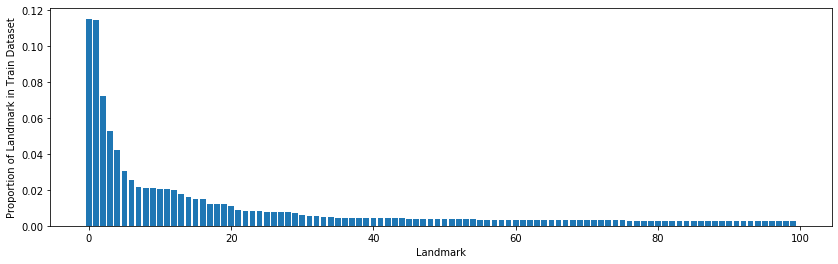

In [13]:
plt.figure(figsize = (14, 4))
fig = plt.bar(range(100), landmark_dist)
plt.xlabel("Landmark")
plt.ylabel("Proportion of Landmark in Train Dataset")
plt.savefig('./report/class_dist.png')

### Manually select two landmark images

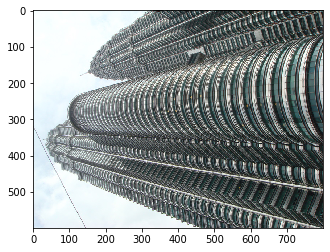

In [14]:
import cv2
img = cv2.imread('./train_images/1e67f4466c315b98.jpg')
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(cv_rgb)
plt.show()

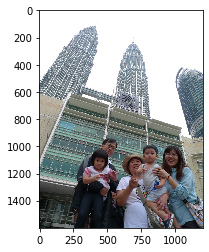

In [15]:
img = cv2.imread('./train_images/2a45e15f4c7f6d2c.jpg')
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(cv_rgb)
plt.show()

## Split dataset into train, validation and test

### Stratified sampling of training, validation and test dataset with 0.8, 0.1 and 0.1 split

In [16]:
from sklearn.model_selection import StratifiedShuffleSplit

X = train_sample['id']
y = train_sample['landmark_id']

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=10)

for train_id, test_id in sss.split(X, y):
    X_train, X_tmp = X.iloc[train_id], X.iloc[test_id]
    y_train, y_tmp = y.iloc[train_id], y.iloc[test_id]
    
sss1 = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=10)

for train_id, test_id in sss1.split(X_tmp, y_tmp):
    X_valid, X_test = X_tmp.iloc[train_id], X_tmp.iloc[test_id]
    y_valid, y_test = y_tmp.iloc[train_id], y_tmp.iloc[test_id]

### Frequency of landmark_id in training dataset

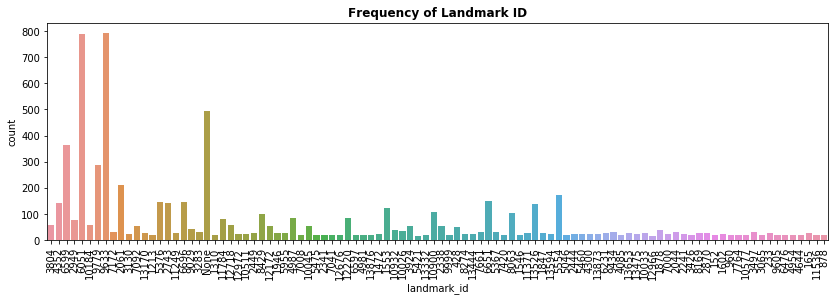

In [17]:
plt.figure(figsize = (14, 4))
h = sns.countplot(x=y_train)
h.set_title("Frequency of Landmark ID", fontweight="bold", fontsize=12)
plt.xticks(rotation=90)
plt.show()

### Frequency of landmark_id in test dataset

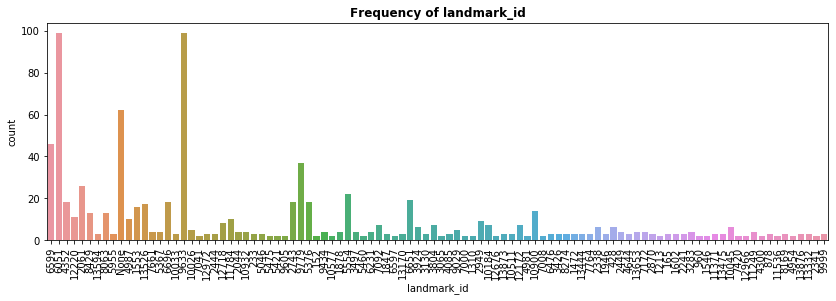

In [18]:
plt.figure(figsize = (14, 4))
h = sns.countplot(x=y_test)
h.set_title("Frequency of landmark_id", fontweight="bold", fontsize=12)
plt.xticks(rotation=90)
plt.show()

## Benchmark Model - Random Guessing as base model
### Expected accuracy

In [19]:
from itertools import combinations

def expected_acc(prob_id):
    
    prob_id_c = 1 - prob_id
    prob_correct_number = []

    for i in range(len(prob_id)+1):

        id_comb = list(combinations(range(len(prob_id)), r=i))
        
        id_notcomb = [tuple(set(range(len(prob_id)))^set(x)) for x in id_comb]

        prob_comb = np.array([[prob_id[x] for x in id_comb[i]] for i in range(len(id_comb))])
        prob_notcomb = np.array([[prob_id_c[x] for x in id_notcomb[i]] for i in range(len(id_notcomb))])

        prob_num = np.hstack((prob_comb, prob_notcomb))
        ss = sum([np.prod(x) for x in prob_num])

        prob_correct_number.append(ss)

    expected_correct_num = sum(np.array(range(len(prob_id)+1)) * np.array(prob_correct_number))
    expected_accuracy = expected_correct_num / len(prob_id)
    
    return([expected_correct_num, expected_accuracy])

### Monte Carlo simulation of expected accuracy

In [20]:
import random

### Calculate probability of correctly classifying a landmark_id, P(id)

# prob_id = np.array([0.25, 0.1]) # Example try out given the probability of two images

# Calculates probabilities of all landmark_id
print(y_test.head())
prob_id = np.array([(y_test == id).sum() / len(y_test) for id in y_test]) 
seed = [3, 10, 27, 31, 48, 55, 67, 95, 105, 117]

expected_val_df = pd.DataFrame(columns=['E(x)', 'Accuracy'])

for i in seed:
    random.seed(i)
    randsample = random.sample(range(len(y_test)), 10)
    
    prob_id_montecarlo = prob_id[randsample]  # random selection of 20 images (instead of total test dataset)
    expected_val_df.loc[len(expected_val_df)] = expected_acc(prob_id_montecarlo)

516997      6599
1002842     6051
992271      4352
1140249     6051
537920     12220
Name: landmark_id, dtype: object


In [21]:
expected_val_df

,E(x),Accuracy
0,0.421420,0.042142
1,0.456345,0.045634
2,0.890570,0.089057
3,0.376019,0.037602
4,0.403958,0.040396
5,0.557625,0.055763
6,0.450524,0.045052
7,0.493597,0.049360
8,0.282887,0.028289
9,0.462165,0.046217


In [22]:
round(expected_val_df.T,3)

,0,1,2,3,4,5,6,7,8,9
E(x),0.421,0.456,0.891,0.376,0.404,0.558,0.451,0.494,0.283,0.462
Accuracy,0.042,0.046,0.089,0.038,0.040,0.056,0.045,0.049,0.028,0.046


In [23]:
expected_val_df.mean()

E(x)        0.479511
Accuracy    0.047951
dtype: float64

## Create Train, Validation and Test Tensors for CNN

In [24]:
import os
from keras.preprocessing import image  
from tqdm import tqdm

img_shape = (192, 256) # Image shape (height, width)

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    ret = np.empty([192, 256, 3], dtype=int)
    if os.path.exists(img_path):
        try:
            img = image.load_img(img_path, target_size=img_shape)
            # convert PIL.Image.Image type to 3D tensor with shape (192, 256, 3)
            ret = image.img_to_array(img)
        except:
            pass
        # convert 3D tensor to 4D tensor with shape (1, 192, 256, 3) and return 4D tensor
        return  np.expand_dims(ret, axis=0)


def paths_to_tensor(img_paths):
    list_of_tensors = []
    for img_path in img_paths:
        tensor = path_to_tensor(img_path)
        list_of_tensors.append(tensor)
    print(len(list_of_tensors))
    return np.vstack(list_of_tensors)

Using TensorFlow backend.


In [25]:
from glob import glob
import os

# define function to load train, test, and validation datasets
train_path = './train_images/'
valid_path = './valid_images/'
test_path = './test_images/'

def load_dataset(path, train_sample):
    file_out = sorted(glob(path + '*'))
    file_out = np.array([s.replace("\\", "/") for s in file_out])
    
    label_out = pd.Series(name="landmark_id")
    
    for file in file_out:
        filebase = os.path.basename(file)
        name = os.path.splitext(filebase)[0]
        temp = train_sample.landmark_id[train_sample["id"] == name]
        label_out = label_out.append(temp)
        
    label_out = np.array(pd.get_dummies(label_out))
    
    return file_out, label_out

In [26]:
train_file, train_target = load_dataset(train_path, train_sample)
valid_file, valid_target = load_dataset(valid_path, train_sample)
test_file, test_target = load_dataset(test_path, train_sample)

In [27]:
print("Number of training images:", len(train_target))
print("Number of validation images:", len(valid_target))
print("Number of test images:", len(test_target))

Number of training images: 6373
Number of validation images: 797
Number of test images: 797


In [28]:
train_tensors = paths_to_tensor(train_file).astype('float32')/255
valid_tensors = paths_to_tensor(valid_file).astype('float32')/255
test_tensors  = paths_to_tensor(test_file).astype('float32')/255

//anaconda3/envs/env/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


6373
797
797


In [29]:
train_tensors.shape

(6373, 192, 256, 3)

### An exmple image of a train tensor and label

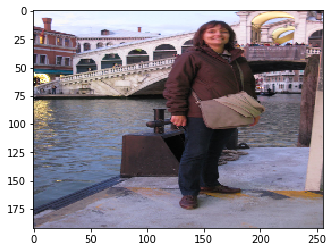

In [30]:
plt.imshow(train_tensors[2])

In [31]:
train_target[2].shape


(99,)

## Base CNN Model
### Model Compile

In [32]:
from keras import optimizers
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

In [33]:
input_shape = img_shape + (3,)

model = Sequential()

model.add(Conv2D(filters=16, kernel_size=4, padding='same', activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=128, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=256, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(99, activation='softmax'))

model.summary()

W0926 19:50:54.342782 4484236736 deprecation_wrapper.py:119] From //anaconda3/envs/env/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0926 19:50:56.337821 4484236736 deprecation_wrapper.py:119] From //anaconda3/envs/env/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0926 19:50:58.253604 4484236736 deprecation_wrapper.py:119] From //anaconda3/envs/env/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0926 19:50:59.138793 4484236736 deprecation_wrapper.py:119] From //anaconda3/envs/env/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0926 19:50:59.559036 4484236736 de

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 192, 256, 16)      784       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 96, 128, 16)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 96, 128, 32)       4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 48, 64, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 48, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 24, 32, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 32, 128)       32896     
__________

In [34]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

W0926 19:51:03.447691 4484236736 deprecation_wrapper.py:119] From //anaconda3/envs/env/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0926 19:51:03.482262 4484236736 deprecation_wrapper.py:119] From //anaconda3/envs/env/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.



### Model Train

In [36]:
from keras.callbacks import ModelCheckpoint

epochs = 10

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_baseCNN.hdf5', 
                               verbose=1, save_best_only=True)

hist = model.fit(train_tensors, train_target, 
          validation_data=(valid_tensors, valid_target),
          epochs=epochs, batch_size=64, callbacks=[checkpointer], verbose=1)

Train on 6373 samples, validate on 797 samples
Epoch 1/10
6373/6373 [==============================] - 741s 116ms/step - loss: 3.8909 - acc: 0.1462 - val_loss: 4.0121 - val_acc: 0.1455

Epoch 00001: val_loss improved from inf to 4.01213, saving model to saved_models/weights.best.from_baseCNN.hdf5
Epoch 2/10
6373/6373 [==============================] - 726s 114ms/step - loss: 3.7157 - acc: 0.1867 - val_loss: 3.7967 - val_acc: 0.2146

Epoch 00002: val_loss improved from 4.01213 to 3.79670, saving model to saved_models/weights.best.from_baseCNN.hdf5
Epoch 3/10
6373/6373 [==============================] - 717s 112ms/step - loss: 3.4779 - acc: 0.2264 - val_loss: 3.5277 - val_acc: 0.2434

Epoch 00003: val_loss improved from 3.79670 to 3.52774, saving model to saved_models/weights.best.from_baseCNN.hdf5
Epoch 4/10
6373/6373 [==============================] - 718s 113ms/step - loss: 3.1765 - acc: 0.2823 - val_loss: 3.2221 - val_acc: 0.2923

Epoch 00004: val_loss improved from 3.52774 to 3.2220

### Test Accuracy

In [37]:
model.load_weights('saved_models/weights.best.from_baseCNN.hdf5')

landmark_pred = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]
test_accuracy = np.sum(np.array(landmark_pred) == np.argmax(test_target, axis=1)) / len(landmark_pred)
print('Test accuracy:', test_accuracy)

Test accuracy: 0.4077791718946048


## Data Augmentation

### Model Train

In [38]:
train_datagen = ImageDataGenerator(
    rotation_range=45, 
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    zoom_range=0.3)

valid_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(train_tensors, train_target, batch_size= 128)
valid_generator = valid_datagen.flow(valid_tensors, valid_target, batch_size= 128)

In [ ]:
epochs_aug = 50

hist_aug = model.fit_generator(train_generator, steps_per_epoch=6480//128, epochs=epochs_aug,
                    validation_data=valid_generator, validation_steps=805//128,
                    callbacks=[checkpointer], verbose=1)

Epoch 1/50


### Test Accuracy

In [ ]:
model.load_weights('saved_models/weights.best.from_baseCNN.hdf5')

landmark_pred = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]
landmark_prob = [np.amax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]
test_accuracy = np.sum(np.array(landmark_pred) == np.argmax(test_target, axis=1)) / len(landmark_pred)
print('Test accuracy:', test_accuracy)

## Global Average Precision (GAP) Evaluation

In [ ]:
# Sort the predicted landmark lable and test label based on softmax probability

sort_id = np.argsort(landmark_prob)[::-1]
landmark_pred_sorted = [landmark_pred[sid] for sid in sort_id]
test_target_sorted = [test_target[sid] for sid in sort_id]

In [ ]:
# Calculate GAP score

prec = []

for i in range(len(sort_id)):
    prec.append(np.sum(np.array(landmark_pred_sorted[:(i+1)]) == np.argmax(test_target_sorted[:(i+1)], axis=1)) 
                / len(landmark_pred_sorted[:(i+1)]))

GAP_score = np.sum(prec) / len(prec)
GAP_score

## CNN with Batch Normalization
### Model Compile

In [ ]:
modelBN = Sequential()

modelBN.add(Conv2D(filters=16, kernel_size=4, padding='same', use_bias=False, input_shape=input_shape))
modelBN.add(Activation("relu"))
modelBN.add(BatchNormalization())
modelBN.add(MaxPooling2D(pool_size=2))

modelBN.add(Conv2D(filters=32, kernel_size=3, padding='same', use_bias=False))
modelBN.add(Activation("relu"))
modelBN.add(BatchNormalization())
modelBN.add(MaxPooling2D(pool_size=2))

modelBN.add(Conv2D(filters=64, kernel_size=3, padding='same', use_bias=False))
modelBN.add(Activation("relu"))
modelBN.add(BatchNormalization())
modelBN.add(MaxPooling2D(pool_size=2))

modelBN.add(Conv2D(filters=128, kernel_size=2, padding='same', use_bias=False))
modelBN.add(Activation("relu"))
modelBN.add(BatchNormalization())
modelBN.add(MaxPooling2D(pool_size=2))

modelBN.add(Flatten())
modelBN.add(Dense(512, activation='relu'))
modelBN.add(Dropout(0.3))
modelBN.add(Dense(100, activation='softmax'))

modelBN.summary()

In [ ]:
adam = optimizers.Adam(lr=0.02)
modelBN.compile(optimizer='adamax', loss='categorical_crossentropy', metrics=['accuracy'])

### Model Train

In [ ]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_BatchNorm.hdf5', 
                               verbose=1, save_best_only=True)

epochs_batch = 15

hist_BN = modelBN.fit(train_tensors, train_target, 
          validation_data=(valid_tensors, valid_target),
          epochs=epochs_batch, batch_size=64, callbacks=[checkpointer], verbose=1)

### Test Acccuracy

In [ ]:
modelBN.load_weights('saved_models/weights.best.from_BatchNorm.hdf5')

landmark_pred = [np.argmax(modelBN.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]
test_accuracy = np.sum(np.array(landmark_pred) == np.argmax(test_target, axis=1)) / len(landmark_pred)
print('Test accuracy:', test_accuracy)

## Model Evaluation

In [ ]:
hist_BaseCNN = {'acc': [0.13132716049382717, 0.17654320987654321, 0.22330246913580246, 0.28456790123456788, 0.36003086419753089,
                        0.44645061728395063, 0.54243827160493829, 0.65416666666666667, 0.75169753086419755, 0.8246913580246914],
                'loss': [3.9298892386165667, 3.680104664814325, 3.3804817258575817, 3.066348374920127, 2.6730856707066666,
                         2.2241253917599901, 1.7646778118463211, 1.286705630502583, 0.87414459122551813, 0.60244603024588694],
                'val_acc': [0.17142857183580812, 0.19751552835754727, 0.24472049730164663, 0.29565217420921563,
                            0.37391304407060516, 0.3913043485294958, 0.43229813649787668, 0.4211180122742742,
                            0.42484472160753994, 0.41987577687879529],
                'val_loss': [3.7763777463332469, 3.5307922268506164, 3.2851792984127259, 2.9763647654041741, 2.737886569514778,
                             2.6325608985024211, 2.5756296847918021, 2.7493783006016512, 2.8917108950407608,3.2256962965734255]}

In [ ]:
hist_BaseCNN_df = pd.DataFrame(hist_BaseCNN)
hist_BaseCNN_df.columns = ['Train_acc', 'Train_loss', 'Val_acc','Val_loss']
hist_BaseCNN_df

In [ ]:
ax1 = hist_BaseCNN_df.plot(marker='.')
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Value")
plt.savefig('./Report/base.png')

In [ ]:
hist_Aug1 = {'acc': [0.25546875000000002, 0.29408060445893619, 0.30462846340100169, 0.33674433294411571, 0.34146725470833572,
                     0.35941435768261965, 0.35925692687707222, 0.38365868995111596, 0.38727959705239878, 0.40192065483676997,
                     0.4208123424191319, 0.42191435753248202, 0.43938916906601838, 0.45560453385490013, 0.46221662491034499,
                     0.46300377878794441, 0.49071158705190088, 0.48598866498740556, 0.50519521410579349, 0.51243702770780852,
                     0.51338161254109305, 0.53494962246652211, 0.5469143573823444, 0.54738665017433075, 0.54707178841309823,
                     0.55919395450981202, 0.57761335027608218, 0.58705919470534818, 0.58658690161308658, 0.59382871551537697,
                     0.60862720418036431, 0.61319269506396812, 0.60799748125844999, 0.62043450881612094, 0.61791561727860111,
                     0.62641687627403198, 0.63082493747812074, 0.6460957172835804, 0.650818640098764, 0.64798488710028701,
                     0.6527078087143694, 0.66593198977429557, 0.67726700341971757, 0.67742443324937029, 0.67333123395665162,
                     0.67553526448362722, 0.68246221707509802, 0.69285264483627207, 0.7029282120373147, 0.69899244302466179,
                     0.71630982307703128, 0.6985201511335013, 0.71048488634959872, 0.71656249999999999, 0.71505037813402839,
                     0.71977329974811088, 0.7282745596443676, 0.73646095747911655, 0.73803526478390247, 0.75409319944285624],
             'loss': [3.2232321786880491, 2.9990468968071924, 2.9238310268603884, 2.7992355565280098, 2.737023192028555,
                      2.6451771565588658, 2.6298042989197548, 2.5292290740409484, 2.4872682490937357, 2.4218320276034571,
                      2.3226811627596993, 2.299093459655416, 2.2177092599628554, 2.2043386424518654, 2.1157339285843317,
                      2.0904880164552395, 2.0064047355795989, 1.9939596881193837, 1.9514757896250381, 1.9008020567954036,
                      1.876178127392113, 1.782965435489299, 1.7345330483967472, 1.7294392582751641, 1.7163397094764998,
                      1.6662033177743329, 1.6024818057077057, 1.5661355632378413, 1.5691469054978802, 1.5227450225455335,
                      1.469195683597017, 1.4539444128271914, 1.4576934302784033, 1.4022760595422548, 1.3867993583006581,
                      1.3635792876370909, 1.3296321273150311, 1.2845476106071954, 1.265174487676068, 1.2719144436814622,
                      1.2758843298222615, 1.2146366297147737, 1.1755962930338208, 1.163139341460067, 1.1503687775705562,
                      1.1531679134825314, 1.1188850982363339, 1.0898135984574517, 1.0535212247738008, 1.0678208411790862,
                      1.0192861403866438, 1.0809404141356422, 1.0331504585160416, 0.98859515905380246, 1.00419298527523,
                      0.99700506358062591, 0.96955797684282741, 0.93192633513539502, 0.91039594775183075, 0.87640107939165246],
             'val_acc': [0.3828125, 0.39438700367816265, 0.39881831830150094, 0.41802068092094036, 0.44313146339033344,
                         0.46233382715432297, 0.4357459379175741, 0.45963541666666669, 0.49778434414102901, 0.46971935113036301,
                         0.48596750562969304, 0.50516986899749217, 0.50516986987791523, 0.56129985396231652,0.54036458333333337,
                         0.52437223298158742, 0.52732644299460651, 0.55096012248246318, 0.5509601204574901, 0.57607090182635423,
                         0.56129985721988196, 0.5703125, 0.58345642646271156, 0.60265879071093376, 0.58345642646271156,
                         0.59084195171536513, 0.60856720959242194, 0.59379616120013035, 0.62239583333333337,0.64106351806282824,
                         0.61595273519724481, 0.64254062117642807, 0.61742983654999839, 0.66469719640613478,
                         0.62629246579667486, 0.62630208333333337, 0.64844904129050862, 0.63810930505637053,
                         0.62924667906725951, 0.673559824420219, 0.6528803561779738, 0.64401772605087415, 0.65625,
                         0.64254062267314738, 0.63515509856504382, 0.64844904155463556, 0.66322008880237704, 0.6661743015447078,
                         0.68537666227123761, 0.65625, 0.66322008941867328, 0.68094534703160314, 0.67355982265937275,
                         0.70162481439342528, 0.68833087492552603, 0.68389955678049541, 0.68489583333333337, 0.692762186643468,
                         0.68537666517663387, 0.67651403478540728],
             'val_loss': [2.6452309290568032, 2.5847700216217264, 2.4060148689208036, 2.3356332831756053, 2.3420486395609079,
                          2.3017310786282472, 2.3716619233084923, 2.2140320539474487, 2.0899026453759153, 2.1580345694036218,
                          2.0487872564634158, 2.0332463872309448, 2.0096049868725956, 1.9020438509466377, 1.9020523428916931,
                          1.8518806903717966, 1.7829044162786869, 1.8370949434917117, 1.845528794180167, 1.7594302035152825,
                          1.8055269017353368, 1.6822096308072407, 1.7357862992335986, 1.6300792472225172, 1.7285163599772151,
                          1.6977536676553362, 1.6085897534425362, 1.6361149172663161, 1.5901709794998169, 1.484190075929267,
                          1.5790710727432453, 1.5120298226791788, 1.4797959715964346, 1.4832501860453775, 1.5785681849216253,
                          1.554775059223175, 1.4138278459340465, 1.3956891520160692, 1.5429726955281402, 1.3938687219225321,
                          1.4762555027994131, 1.4691717006607281, 1.4483438928922017, 1.4830871012221412, 1.4592810141987427,
                          1.4282475282029528, 1.425352577796891, 1.337258996780373, 1.3461823303202936, 1.4805522759755452,
                          1.3543041685659389, 1.2878402416075703, 1.391042958510327, 1.3276069699573376, 1.279264172035623,
                          1.3356382948961356, 1.367376983165741, 1.3885350897357946, 1.4288017251466896, 1.3429765403710934]}

In [ ]:
hist_Aug1_df = pd.DataFrame(hist_Aug1)
hist_Aug1_df.columns = ['Train_acc', 'Train_loss', 'Val_acc','Val_loss']
hist_Aug1_df.head()

In [ ]:
ax2 = hist_Aug1_df.plot(marker='.')
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Value")
plt.savefig('./Report/aug.png')